In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date, time
from sklearn.preprocessing import normalize

import utils.metrics as metrics
import preprocessing.extra_points_removing as epr
import preprocessing.data_loading as data_loading

In [12]:
df = data_loading.load_train_dataframe()
df_test = data_loading.load_test_dataframe()

In [14]:
df.head()

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,total_seconds,delta_time
0,0,2014-01-01T00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133,0.000,2803.000
1,1,2014-01-01T00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468,2803.000,2803.000
2,2,2014-01-01T01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768,5606.001,2803.001
3,3,2014-01-01T02:20:09.001,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306,8409.001,2803.000
4,4,2014-01-01T03:06:52.002,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237,11212.002,2803.001


Описание полей датасета:
- id - integer measurement id
- epoch — datetime in "%Y-%m-%dT%H:%M:%S.%f” format (like 2014-02-01T00:44:57.685)
- sat_id — integer satellite id
- (x, y, z), (x_sim, y_sim, z_sim)	реальные (полученные с помощью точного симулятора) и смоделированные (полученные с помощью симулятора SGP4) координаты спутника (км)
- реальные (полученные с помощью точного симулятора) и смоделированные (полученные с помощью симулятора SGP4) скорости спутника (км / с)

In [10]:
satellite_true_values = df[['x', 'y', 'z', 'Vx', 'Vy', 'Vz']].to_numpy()
satellite_predicted_values = df[['x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim']].to_numpy()

print(metrics.smape(satellite_predicted_values, satellite_true_values))
print(metrics.score(satellite_predicted_values, satellite_true_values))

0.15973600741329672
84.02639925867032


## Сопоставление данных из тестовой и обучающей выборок для одного спутника

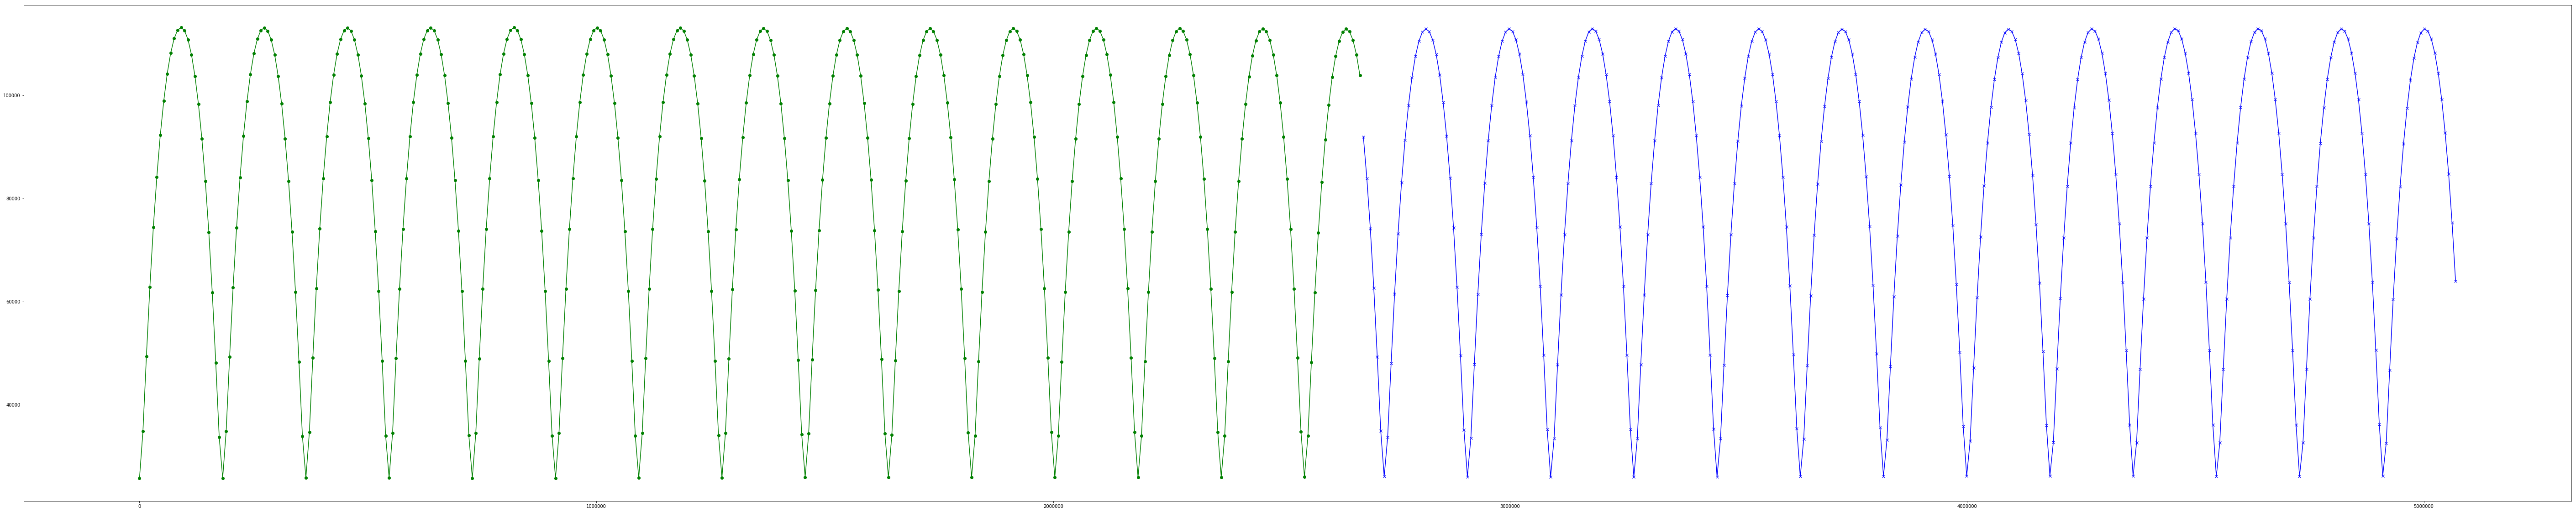

In [11]:
index = 3

plt.figure(figsize = (100, 20))
sat = df[df.sat_id==index]

x = sat['total_seconds']

y=(sat.x_sim**2 + sat.y_sim**2 + sat.z_sim**2)**0.5
plt.plot(x,y,'-go')

sat = df_test[df_test.sat_id==index]
x = sat['total_seconds']

y=(sat.x_sim**2 + sat.y_sim**2 + sat.z_sim**2)**0.5
plt.plot(x,y,'-bx')

plt.show()

## Визуализация расстояния между реальными и симулированными координатами

In [ ]:
df['error'] = ((df.x-df.x_sim)**2+(df.y-df.y_sim)**2+(df.z-df.z_sim)**2)**0.5

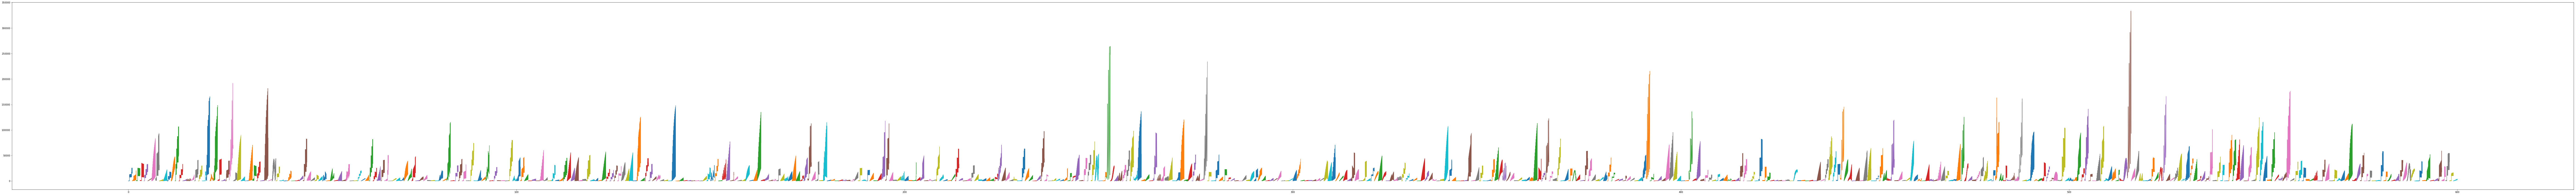

In [7]:
plt.figure(figsize = (200, 15))

for i in range(0,600):
    n = len(df[df['sat_id']==i])
    
    x = np.linspace(1.0 * i, 1.0 * (i+1), num=n)
    
    y = df[df['sat_id']==i]['error']
    #y=y-y.min()
    #y=y/y.max()
    
    plt.plot(x,y)
plt.show()

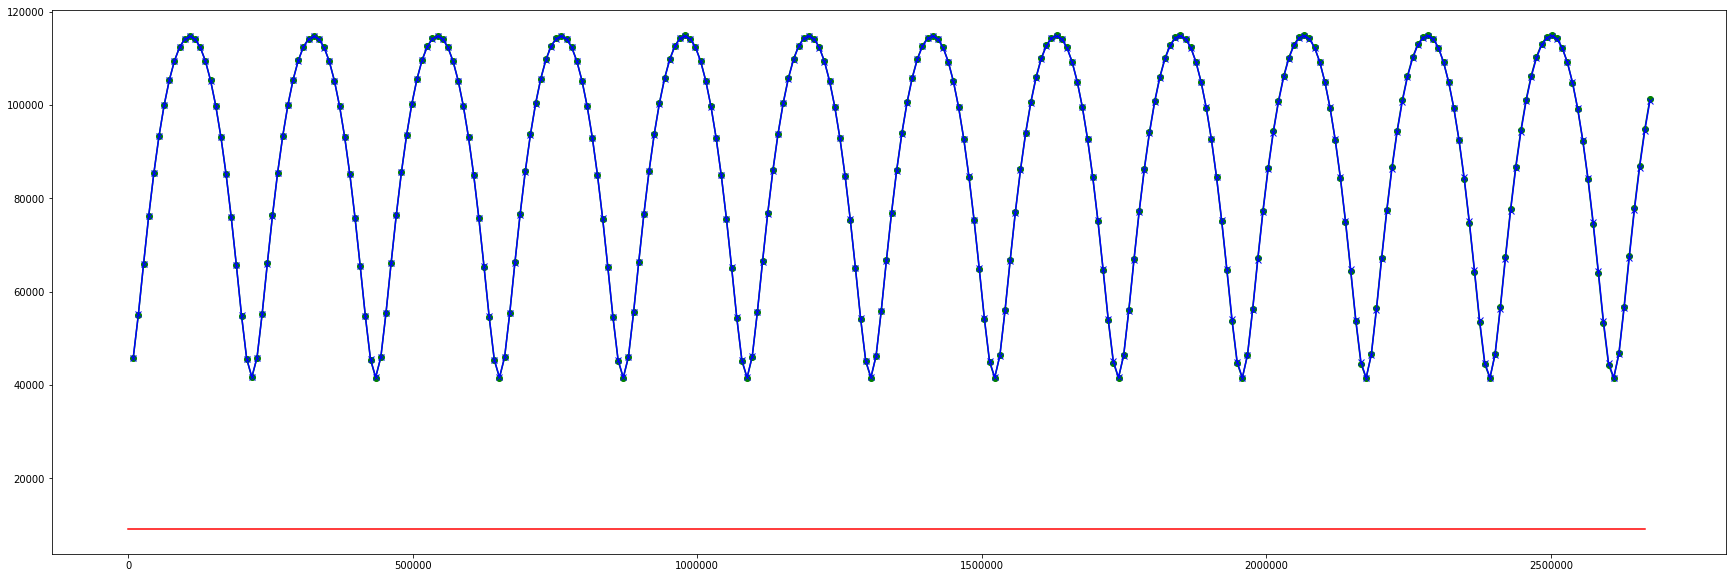

41515.747088490636


In [6]:
plt.figure(figsize = (30, 10))
sat = df[df.sat_id==12]

#x = np.linspace(0.0, 1.0, num=len(sat))
x = sat['total_seconds']

y=(sat.x**2 + sat.y**2 + sat.z**2)**0.5
plt.plot(x,y, '-go')

x = sat['total_seconds']
y=(sat.x_sim**2 + sat.y_sim**2 + sat.z_sim**2)**0.5
plt.plot(x,y, '-bx')

x = np.linspace(0.0, sat['total_seconds'].max(), num=len(sat))


plt.plot(x, sat['total_seconds'].diff().shift(-1), '-r')

plt.show()
print(y.min())

In [303]:
df_test[['x', 'y', 'z', 'Vx', 'Vy', 'Vz']] = \
    df_test[['x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim']]

for sat_id in df_test['sat_id'].unique():
    sat = df_test[df_test.sat_id==sat_id]
    sat_array = sat[['x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim']].to_numpy()
    new_sat_array = sat[['x', 'y', 'z', 'Vx', 'Vy', 'Vz']].to_numpy()
    
    j = 0
    for i, dt in enumerate(sat['total_seconds'].diff().shift(-1)):
        new_sat_array[i] = sat_array[i-j]
        if dt < 1:
            j+=1
    
    sat[['x', 'y', 'z', 'Vx', 'Vy', 'Vz']]=new_sat_array
    df_test[df_test.sat_id==sat_id]=sat

C:\Users\79105\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


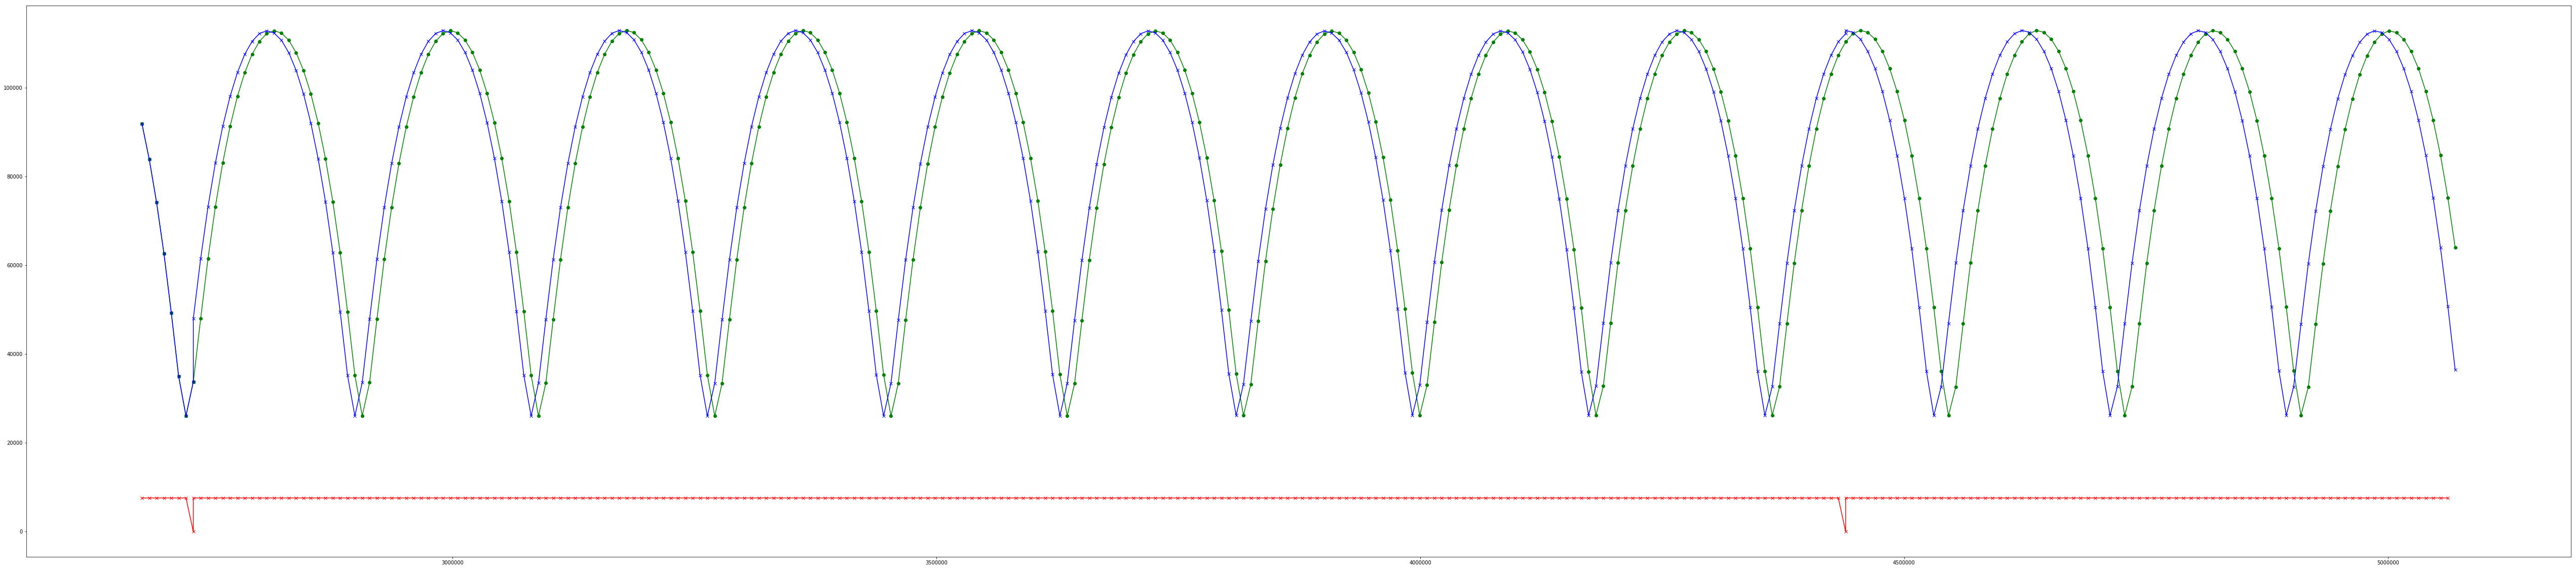

In [304]:
plt.figure(figsize = (90, 20))

sat = df_test[df_test.sat_id==3]

x = sat['total_seconds']

y=(sat.x**2 + sat.y**2 + sat.z**2)**0.5
plt.plot(x,y, '-go')

x = sat['total_seconds']
y=(sat.x_sim**2 + sat.y_sim**2 + sat.z_sim**2)**0.5
plt.plot(x,y, '-bx')

#x = np.linspace(0.0, sat['total_seconds'].max(), num=len(sat))


plt.plot(x, sat['total_seconds'].diff().shift(-1), '-rx')

plt.show()

In [40]:
submission = pd.read_csv("data/submission.csv")
submission[['x', 'y', 'z', 'Vx', 'Vy', 'Vz']]=df_test[['x', 'y', 'z', 'Vx', 'Vy', 'Vz']]
submission.to_csv("data/output_submission.csv",index=False,sep=',')